# Multi-Task Learning (MTL) with PyTorch: A Comprehensive Tutorial

**Author**: MTL Tutorial Series  
**Purpose**: Interview Preparation & Practical Implementation Guide

---

## 📚 Table of Contents

1. [Introduction to Multi-Task Learning](#introduction)
2. [Interview Questions & Answers](#interview-prep)
3. [Implementation: Setup & Imports](#setup)
4. [Dataset Preparation](#dataset)
5. [Model Architecture](#architecture)
6. [Training Loop](#training)
7. [Evaluation & Visualization](#evaluation)
8. [Best Practices](#best-practices)
9. [Production Considerations](#production)

---

## 1. Introduction to Multi-Task Learning <a name="introduction"></a>

### What is Multi-Task Learning?

**Multi-Task Learning (MTL)** is a machine learning paradigm where a model is trained to perform multiple related tasks simultaneously. Instead of training separate models for each task, MTL leverages shared representations to improve generalization and efficiency.

### Key Concepts

1. **Shared Encoder**: Common feature extractor used by all tasks
2. **Task-Specific Heads**: Separate output layers for each task
3. **Joint Loss**: Combined loss from all tasks guides training
4. **Transfer Learning**: Knowledge from one task helps others

### Architecture Diagram

```
                    Input (28x28 MNIST Image)
                             |
                             v
                    ┌────────────────┐
                    │ Shared Encoder │
                    │   (Conv Layers)│
                    │   + Flatten    │
                    └────────┬───────┘
                             │
              ┌──────────────┼──────────────┐
              │              │              │
         ┌────v────┐    ┌───v────┐    ┌────v────┐    ┌──────v──────┐
         │ Task 1  │    │ Task 2 │    │ Task 3  │    │   Task 4    │
         │ Head    │    │ Head   │    │ Head    │    │   Head      │
         └────┬────┘    └───┬────┘    └────┬────┘    └──────┬──────┘
              │             │              │                 │
         Digit(0-9)    Even/Odd      Greater>4        Norm Value
        (10 classes)   (2 classes)   (2 classes)      (Regression)
```

### Benefits of MTL

- **Better Generalization**: Shared representations act as regularization
- **Data Efficiency**: Tasks with more data help tasks with less data
- **Faster Training**: One model instead of multiple
- **Reduced Overfitting**: Implicit regularization from multiple objectives
- **Resource Efficient**: Single inference pass for all tasks

### Our Example: MNIST Multi-Task

We'll train a single model to perform **4 tasks** on MNIST digits:

1. **Task 1**: Digit Classification (0-9) — 10-class classification
2. **Task 2**: Even/Odd Classification — Binary classification
3. **Task 3**: Greater than 4? — Binary classification  
4. **Task 4**: Normalized Value — Regression (0.0-1.0)

## 2. Interview Questions & Answers <a name="interview-prep"></a>

### Q1: What is Multi-Task Learning and why use it?

**Answer**: Multi-Task Learning is a training paradigm where a single model learns to solve multiple related tasks simultaneously by sharing representations. We use it because:
- Shared representations improve generalization (acts as inductive bias)
- Data-efficient: tasks with more data help tasks with sparse data
- Computationally efficient: one model serves multiple purposes
- Implicit regularization reduces overfitting

### Q2: What's the difference between MTL and Transfer Learning?

**Answer**: 
- **Transfer Learning**: Train on Task A, then fine-tune on Task B (sequential)
- **Multi-Task Learning**: Train on Tasks A & B simultaneously (parallel)
- MTL learns shared representations optimized for all tasks jointly
- Transfer learning adapts a pre-trained model to a new domain

### Q3: How do you handle different loss scales in MTL?

**Answer**: Several approaches:
1. **Loss Weighting**: Manually tune weights (α₁, α₂, ...) for each loss
2. **Uncertainty Weighting**: Learn task-dependent uncertainty parameters
3. **GradNorm**: Balance gradient magnitudes across tasks
4. **Dynamic Task Prioritization**: Adjust weights based on task difficulty
5. **Normalization**: Scale losses to similar ranges

In practice, start with equal weights and tune based on validation performance.

### Q4: What are common challenges in MTL?

**Answer**:
1. **Negative Transfer**: Tasks hurt each other (choose related tasks)
2. **Task Balancing**: Some tasks dominate training
3. **Catastrophic Interference**: New task learning hurts old tasks
4. **Architecture Design**: Finding optimal sharing structure
5. **Hyperparameter Tuning**: More complex than single-task

### Q5: When should you NOT use MTL?

**Answer**: Avoid MTL when:
- Tasks are unrelated (no benefit from shared representations)
- One task has significantly more data (may dominate)
- Tasks require very different architectures
- Latency is critical (single-task models can be more optimized)
- Tasks have conflicting objectives

### Q6: How do you design the architecture (hard vs soft sharing)?

**Answer**:
- **Hard Parameter Sharing**: Shared encoder + task-specific heads (most common)
  - Pros: Simple, parameter-efficient, strong regularization
  - Cons: Less flexible, potential negative transfer
- **Soft Parameter Sharing**: Separate networks with regularized similarity
  - Pros: More flexible, tasks can diverge
  - Cons: More parameters, complex training

### Q7: How do you evaluate MTL models?

**Answer**:
1. **Per-Task Metrics**: Accuracy, F1, MSE for each task
2. **Average Performance**: Mean across all tasks
3. **Relative Improvement**: Compare to single-task baselines
4. **Task Correlation**: Analyze which tasks help/hurt each other
5. **Efficiency Metrics**: Parameters, FLOPs, latency vs single-task

### Q8: What are practical applications of MTL?

**Answer**: MTL is used in:
- **Computer Vision**: Object detection + segmentation + depth estimation
- **NLP**: Named entity recognition + POS tagging + sentiment
- **Autonomous Driving**: Lane detection + object detection + steering prediction
- **Recommendation Systems**: CTR + conversion + engagement prediction
- **Medical Imaging**: Disease classification + severity grading + localization

## 3. Implementation: Setup & Imports <a name="setup"></a>

In [9]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
HIDDEN_DIM = 128

print("✓ Setup complete!")

Using device: cpu
✓ Setup complete!


## 4. Dataset Preparation <a name="dataset"></a>

### Multi-Task Dataset Wrapper

We create a custom dataset class that wraps MNIST and generates labels for all 4 tasks:
1. Original digit label (0-9)
2. Even/Odd label (0=even, 1=odd)
3. Greater than 4 label (0=≤4, 1=>4)
4. Normalized value (digit/9.0)

In [10]:
class MultiTaskMNIST(Dataset):
    """Wrapper for MNIST that provides labels for all 4 tasks."""
    
    def __init__(self, mnist_dataset):
        self.mnist = mnist_dataset
    
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        image, digit_label = self.mnist[idx]
        
        # Task 1: Digit classification (0-9)
        task1_label = digit_label
        
        # Task 2: Even/Odd classification (0=even, 1=odd)
        task2_label = digit_label % 2
        
        # Task 3: Greater than 4? (0=no, 1=yes)
        task3_label = 1 if digit_label > 4 else 0
        
        # Task 4: Normalized digit value (regression: 0.0 to 1.0)
        task4_label = digit_label / 9.0
        
        return image, {
            'task1': task1_label,      # Classification (10 classes)
            'task2': task2_label,      # Binary classification
            'task3': task3_label,      # Binary classification
            'task4': task4_label       # Regression
        }

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap with multi-task dataset
train_dataset = MultiTaskMNIST(mnist_train)
test_dataset = MultiTaskMNIST(mnist_test)

# Create data loaders
# Note: Set num_workers=0 if you encounter multiprocessing errors on Windows
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches (train): {len(train_loader)}")
print("✓ Dataset ready!")

Train dataset size: 60000
Test dataset size: 10000
Number of batches (train): 469
✓ Dataset ready!


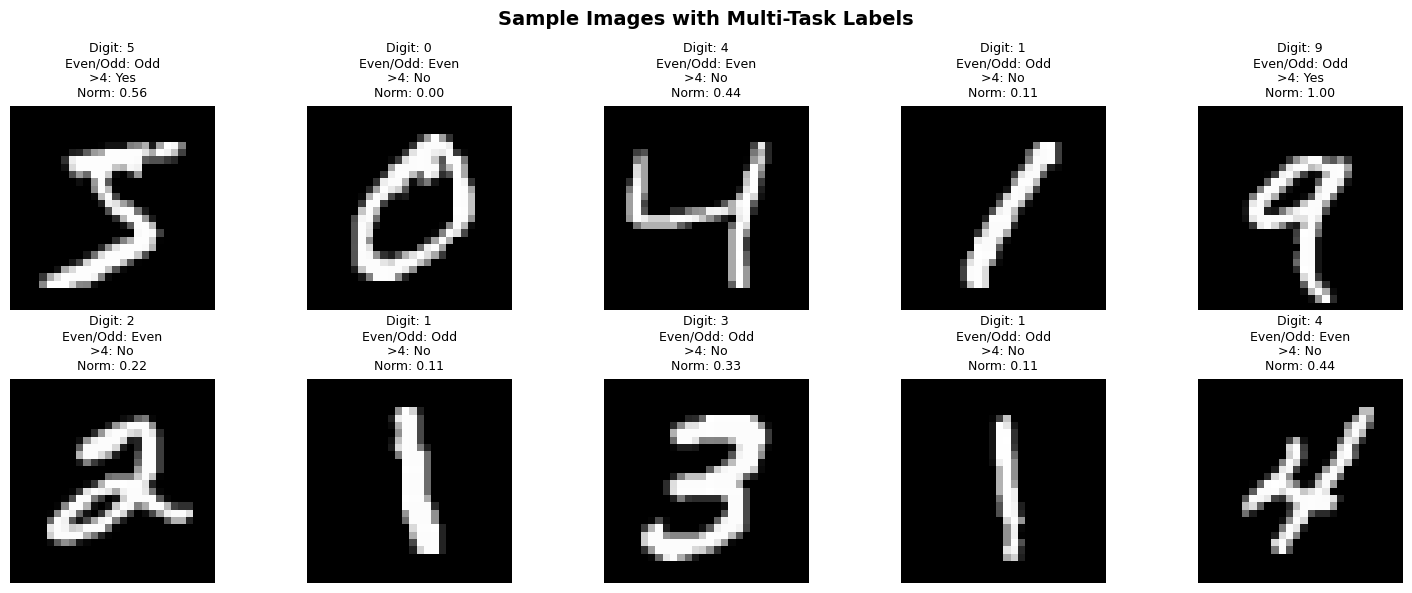

✓ Visualization complete!


In [11]:
# Visualize sample data with all task labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    image, labels = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].axis('off')
    title = f"Digit: {labels['task1']}\n"
    title += f"Even/Odd: {'Odd' if labels['task2'] else 'Even'}\n"
    title += f">4: {'Yes' if labels['task3'] else 'No'}\n"
    title += f"Norm: {labels['task4']:.2f}"
    axes[i].set_title(title, fontsize=9)

plt.suptitle('Sample Images with Multi-Task Labels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

## 5. Model Architecture <a name="architecture"></a>

### Multi-Task Neural Network

Our architecture consists of:
1. **Shared Encoder**: Convolutional layers + pooling (feature extraction)
2. **Task-Specific Heads**: Separate fully connected layers for each task

#### Design Decisions:
- **Shared layers**: Learn general digit representations
- **Task heads**: Specialize for each task's output
- **Batch Normalization**: Improves training stability
- **Dropout**: Prevents overfitting

In [12]:
class MultiTaskCNN(nn.Module):
    """Multi-Task Learning model with shared encoder and task-specific heads."""
    
    def __init__(self, hidden_dim=128):
        super(MultiTaskCNN, self).__init__()
        
        # Shared Encoder: Convolutional layers for feature extraction
        self.encoder = nn.Sequential(
            # Conv Block 1: 1 -> 32 channels
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            
            # Conv Block 2: 32 -> 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
            
            # Flatten: 64 * 7 * 7 = 3136
            nn.Flatten(),
            
            # Shared FC layer
            nn.Linear(64 * 7 * 7, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Task 1 Head: Digit Classification (10 classes)
        self.task1_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 10)
        )
        
        # Task 2 Head: Even/Odd Classification (2 classes)
        self.task2_head = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )
        
        # Task 3 Head: Greater than 4 (2 classes)
        self.task3_head = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )
        
        # Task 4 Head: Normalized Value Regression (1 output)
        self.task4_head = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def forward(self, x):
        # Shared feature extraction
        features = self.encoder(x)
        
        # Task-specific predictions
        task1_out = self.task1_head(features)  # Logits for digit classification
        task2_out = self.task2_head(features)  # Logits for even/odd
        task3_out = self.task3_head(features)  # Logits for >4
        task4_out = self.task4_head(features)  # Regression value
        
        return {
            'task1': task1_out,
            'task2': task2_out,
            'task3': task3_out,
            'task4': task4_out
        }

# Instantiate model
model = MultiTaskCNN(hidden_dim=HIDDEN_DIM).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:\n{model}")
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("✓ Model created!")

Model Architecture:
MultiTaskCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
  )
  (task1_head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
  (task2_head): Sequential(
    (0): Lin

## 6. Training Loop <a name="training"></a>

### Loss Functions

We use appropriate loss functions for each task:
- **Tasks 1, 2, 3**: CrossEntropyLoss (classification)
- **Task 4**: MSELoss (regression)

### Combined Loss

Total Loss = α₁·L₁ + α₂·L₂ + α₃·L₃ + α₄·L₄

where α values are task weights (we'll use equal weights for simplicity)

In [13]:
# Define loss functions
criterion_task1 = nn.CrossEntropyLoss()  # Digit classification
criterion_task2 = nn.CrossEntropyLoss()  # Even/odd
criterion_task3 = nn.CrossEntropyLoss()  # >4
criterion_task4 = nn.MSELoss()           # Normalized value

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (optional but recommended)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Task weights (can be tuned)
task_weights = {
    'task1': 1.0,  # Digit classification
    'task2': 1.0,  # Even/odd
    'task3': 1.0,  # >4
    'task4': 10.0  # Regression (scaled up since MSE is typically smaller)
}

print("✓ Loss functions and optimizer configured!")
print(f"Task weights: {task_weights}")

✓ Loss functions and optimizer configured!
Task weights: {'task1': 1.0, 'task2': 1.0, 'task3': 1.0, 'task4': 10.0}


In [14]:
def train_epoch(model, train_loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    
    epoch_losses = {'task1': 0, 'task2': 0, 'task3': 0, 'task4': 0, 'total': 0}
    
    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        images = images.to(device)
        
        # Move labels to device
        task1_labels = labels['task1'].to(device)
        task2_labels = labels['task2'].to(device)
        task3_labels = labels['task3'].to(device)
        task4_labels = labels['task4'].float().to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute individual losses
        loss1 = criterion_task1(outputs['task1'], task1_labels)
        loss2 = criterion_task2(outputs['task2'], task2_labels)
        loss3 = criterion_task3(outputs['task3'], task3_labels)
        loss4 = criterion_task4(outputs['task4'].squeeze(), task4_labels)
        
        # Combined weighted loss
        total_loss = (task_weights['task1'] * loss1 + 
                      task_weights['task2'] * loss2 + 
                      task_weights['task3'] * loss3 + 
                      task_weights['task4'] * loss4)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Accumulate losses
        epoch_losses['task1'] += loss1.item()
        epoch_losses['task2'] += loss2.item()
        epoch_losses['task3'] += loss3.item()
        epoch_losses['task4'] += loss4.item()
        epoch_losses['total'] += total_loss.item()
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= len(train_loader)
    
    return epoch_losses


def evaluate(model, test_loader, device):
    """Evaluate model on test set."""
    model.eval()
    
    epoch_losses = {'task1': 0, 'task2': 0, 'task3': 0, 'task4': 0, 'total': 0}
    
    # Accuracy counters
    correct = {'task1': 0, 'task2': 0, 'task3': 0}
    total = 0
    
    # For storing predictions and labels (for confusion matrix)
    all_preds = {'task1': [], 'task2': [], 'task3': []}
    all_labels = {'task1': [], 'task2': [], 'task3': []}
    task4_preds = []
    task4_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            images = images.to(device)
            
            task1_labels = labels['task1'].to(device)
            task2_labels = labels['task2'].to(device)
            task3_labels = labels['task3'].to(device)
            task4_labels_batch = labels['task4'].float().to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute losses
            loss1 = criterion_task1(outputs['task1'], task1_labels)
            loss2 = criterion_task2(outputs['task2'], task2_labels)
            loss3 = criterion_task3(outputs['task3'], task3_labels)
            loss4 = criterion_task4(outputs['task4'].squeeze(), task4_labels_batch)
            
            total_loss = (task_weights['task1'] * loss1 + 
                          task_weights['task2'] * loss2 + 
                          task_weights['task3'] * loss3 + 
                          task_weights['task4'] * loss4)
            
            epoch_losses['task1'] += loss1.item()
            epoch_losses['task2'] += loss2.item()
            epoch_losses['task3'] += loss3.item()
            epoch_losses['task4'] += loss4.item()
            epoch_losses['total'] += total_loss.item()
            
            # Calculate accuracies
            _, pred1 = torch.max(outputs['task1'], 1)
            _, pred2 = torch.max(outputs['task2'], 1)
            _, pred3 = torch.max(outputs['task3'], 1)
            
            correct['task1'] += (pred1 == task1_labels).sum().item()
            correct['task2'] += (pred2 == task2_labels).sum().item()
            correct['task3'] += (pred3 == task3_labels).sum().item()
            total += task1_labels.size(0)
            
            # Store predictions for confusion matrix
            all_preds['task1'].extend(pred1.cpu().numpy())
            all_preds['task2'].extend(pred2.cpu().numpy())
            all_preds['task3'].extend(pred3.cpu().numpy())
            
            all_labels['task1'].extend(task1_labels.cpu().numpy())
            all_labels['task2'].extend(task2_labels.cpu().numpy())
            all_labels['task3'].extend(task3_labels.cpu().numpy())
            
            # Store regression predictions
            task4_preds.extend(outputs['task4'].squeeze().cpu().numpy())
            task4_labels.extend(task4_labels_batch.cpu().numpy())
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= len(test_loader)
    
    # Calculate accuracies
    accuracies = {
        'task1': 100 * correct['task1'] / total,
        'task2': 100 * correct['task2'] / total,
        'task3': 100 * correct['task3'] / total
    }
    
    return epoch_losses, accuracies, all_preds, all_labels, task4_preds, task4_labels


print("✓ Training functions defined!")

✓ Training functions defined!


In [15]:
# Training loop
print("Starting training...\n")

history = {
    'train_loss': [],
    'test_loss': [],
    'task1_acc': [],
    'task2_acc': [],
    'task3_acc': []
}

best_test_acc = 0.0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_losses = train_epoch(model, train_loader, optimizer, device)
    
    # Evaluate
    test_losses, accuracies, _, _, _, _ = evaluate(model, test_loader, device)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_losses['total'])
    history['test_loss'].append(test_losses['total'])
    history['task1_acc'].append(accuracies['task1'])
    history['task2_acc'].append(accuracies['task2'])
    history['task3_acc'].append(accuracies['task3'])
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.1f}s)")
    print(f"  Train Loss: {train_losses['total']:.4f} | Test Loss: {test_losses['total']:.4f}")
    print(f"  Task 1 (Digit) Acc: {accuracies['task1']:.2f}%")
    print(f"  Task 2 (Even/Odd) Acc: {accuracies['task2']:.2f}%")
    print(f"  Task 3 (>4) Acc: {accuracies['task3']:.2f}%")
    print()
    
    # Save best model
    avg_acc = (accuracies['task1'] + accuracies['task2'] + accuracies['task3']) / 3
    if avg_acc > best_test_acc:
        best_test_acc = avg_acc
        try:
            torch.save(model.state_dict(), 'best_mtl_model.pth')
            print(f"  → Saved checkpoint (avg acc: {best_test_acc:.2f}%)")
        except Exception as e:
            print(f"  Warning: Could not save checkpoint: {e}")

total_time = time.time() - start_time
print(f"\n✓ Training complete in {total_time:.1f}s!")
print(f"Best average test accuracy: {best_test_acc:.2f}%")

Starting training...



Training:   0%|          | 0/469 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/kartikshenoy/anaconda3/envs/main/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/kartikshenoy/anaconda3/envs/main/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'MultiTaskMNIST' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/kartikshenoy/anaconda3/envs/main/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/kartikshenoy/anaconda3/envs/main/lib/python3.12/multiprocessing/spawn

RuntimeError: DataLoader worker (pid(s) 70649) exited unexpectedly

## 7. Evaluation & Visualization <a name="evaluation"></a>

Let's visualize the training curves and evaluate the model comprehensively.

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['test_loss'], label='Test Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(history['task1_acc'], label='Task 1 (Digit)', marker='o')
axes[1].plot(history['task2_acc'], label='Task 2 (Even/Odd)', marker='s')
axes[1].plot(history['task3_acc'], label='Task 3 (>4)', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Task Accuracies')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training curves plotted!")

In [ ]:
# Load best model and evaluate
import os
if os.path.exists('best_mtl_model.pth'):
    model.load_state_dict(torch.load('best_mtl_model.pth'))
    print("Loaded best model checkpoint\n")
else:
    print("Warning: No checkpoint found. Using current model state.\n")
    print("Make sure you've run the training cell above first!\n")

test_losses, accuracies, all_preds, all_labels, task4_preds, task4_labels = evaluate(model, test_loader, device)

print("="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)
print(f"\nTask 1 (Digit Classification):     {accuracies['task1']:.2f}%")
print(f"Task 2 (Even/Odd Classification):  {accuracies['task2']:.2f}%")
print(f"Task 3 (>4 Classification):        {accuracies['task3']:.2f}%")

# Regression metrics for Task 4
task4_mae = np.mean(np.abs(np.array(task4_preds) - np.array(task4_labels)))
task4_rmse = np.sqrt(np.mean((np.array(task4_preds) - np.array(task4_labels))**2))
print(f"\nTask 4 (Regression):")
print(f"  MAE:  {task4_mae:.4f}")
print(f"  RMSE: {task4_rmse:.4f}")

print("\n" + "="*60)

In [ ]:
# Confusion matrices for classification tasks
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Task 1: Digit Classification
cm1 = confusion_matrix(all_labels['task1'], all_preds['task1'])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Task 1: Digit Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Task 2: Even/Odd
cm2 = confusion_matrix(all_labels['task2'], all_preds['task2'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            xticklabels=['Even', 'Odd'], yticklabels=['Even', 'Odd'], cbar=False)
axes[1].set_title('Task 2: Even/Odd Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Task 3: Greater than 4
cm3 = confusion_matrix(all_labels['task3'], all_preds['task3'])
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', ax=axes[2], 
            xticklabels=['≤4', '>4'], yticklabels=['≤4', '>4'], cbar=False)
axes[2].set_title('Task 3: Greater than 4')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

print("✓ Confusion matrices plotted!")

In [ ]:
# Task 4: Regression visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs True
axes[0].scatter(task4_labels, task4_preds, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('True Normalized Value')
axes[0].set_ylabel('Predicted Normalized Value')
axes[0].set_title('Task 4: Regression Performance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = np.array(task4_preds) - np.array(task4_labels)
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Task 4: Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Regression analysis complete!")

In [ ]:
# Visualize sample predictions
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.flatten()

with torch.no_grad():
    for i in range(10):
        image, labels = test_dataset[i]
        image_tensor = image.unsqueeze(0).to(device)
        
        # Get predictions
        outputs = model(image_tensor)
        
        pred1 = torch.argmax(outputs['task1'], dim=1).item()
        pred2 = torch.argmax(outputs['task2'], dim=1).item()
        pred3 = torch.argmax(outputs['task3'], dim=1).item()
        pred4 = outputs['task4'].squeeze().item()
        
        # Display
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
        
        title = f"True: {labels['task1']} | Pred: {pred1}\n"
        title += f"E/O: {labels['task2']}/{pred2}\n"
        title += f">4: {labels['task3']}/{pred3}\n"
        title += f"Norm: {labels['task4']:.2f}/{pred4:.2f}"
        
        # Color based on correctness
        color = 'green' if pred1 == labels['task1'] else 'red'
        axes[i].set_title(title, fontsize=9, color=color)

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Sample predictions visualized!")

## 8. Best Practices <a name="best-practices"></a>

### 1. Task Selection
- Choose **related tasks** that can benefit from shared representations
- Ensure tasks have some **common structure** or **domain**
- Avoid tasks with conflicting objectives

### 2. Architecture Design
- Start with **hard parameter sharing** (shared encoder + task heads)
- Use **deeper shared layers** for low-level features
- Keep task-specific heads **relatively shallow**
- Consider **task similarity** when deciding sharing depth

### 3. Loss Balancing
- Start with **equal weights**, then tune based on validation
- **Normalize losses** to similar scales (especially regression vs classification)
- Consider **uncertainty weighting** for automatic balancing
- Monitor **per-task losses** during training

### 4. Training Strategy
- Use **batch normalization** for stable training
- Apply **dropout** to prevent overfitting
- Consider **gradient clipping** if training is unstable
- Use **learning rate scheduling**

### 5. Evaluation
- Evaluate **each task separately**
- Compare to **single-task baselines**
- Check for **negative transfer** (MTL worse than single-task)
- Analyze **task correlations**

### 6. Debugging
- If one task dominates: adjust loss weights
- If tasks interfere: reduce shared capacity or use soft sharing
- If training unstable: check loss scales, add normalization
- Visualize **gradient magnitudes** across tasks

### 7. Advanced Techniques
- **GradNorm**: Balance gradient magnitudes
- **Uncertainty Weighting**: Learn task weights automatically
- **Task-Specific Batch Normalization**: Separate BN for each task
- **Cross-Stitch Networks**: Learn task sharing patterns
- **Progressive Neural Networks**: Add capacity per task

## 9. Production Considerations <a name="production"></a>

### Deployment Strategies

#### 1. Model Serving
```python
# Example: TorchScript for production
model.eval()
example_input = torch.randn(1, 1, 28, 28).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save('mtl_model_traced.pt')
```

#### 2. Task Selection at Inference
```python
# Allow clients to request specific tasks
def predict(image, tasks=['task1', 'task2', 'task3', 'task4']):
    outputs = model(image)
    return {task: outputs[task] for task in tasks}
```

#### 3. Monitoring
- Track **per-task accuracy** in production
- Monitor **inference latency**
- Log **task usage patterns**
- Watch for **distribution shift** per task

### Optimization

#### Model Compression
- **Quantization**: Reduce precision (FP32 → INT8)
- **Pruning**: Remove unnecessary connections
- **Knowledge Distillation**: Train smaller student model

#### Inference Optimization
- **Batch inference**: Process multiple images together
- **ONNX Runtime**: Cross-platform deployment
- **TensorRT**: GPU optimization
- **Edge deployment**: Mobile/IoT optimization

### A/B Testing
- Compare MTL vs single-task models
- Test different task weight configurations
- Measure business metrics, not just accuracy

### Maintenance
- Regularly **retrain** with new data
- **Version control** for models and task definitions
- Maintain **rollback capability**
- Document **task dependencies**

### When to Use MTL in Production

✅ **Use MTL when:**
- Multiple related predictions are needed
- Latency budget allows single forward pass
- Tasks share common features
- Resource efficiency is important
- Tasks benefit from joint training

❌ **Avoid MTL when:**
- Tasks are completely unrelated
- Different update frequencies per task
- Critical tasks need maximum accuracy
- Tasks have very different input requirements
- Debugging complexity is unacceptable

## Summary

In this tutorial, we've covered:

1. ✅ **Multi-Task Learning Fundamentals**
   - Concepts and benefits
   - Architecture design
   - Interview questions

2. ✅ **Complete Implementation**
   - Custom multi-task dataset
   - Shared encoder with task-specific heads
   - Combined loss training
   - Comprehensive evaluation

3. ✅ **4 Different Tasks**
   - Digit classification (10 classes)
   - Even/Odd classification (binary)
   - Greater than 4 classification (binary)
   - Normalized value regression (continuous)

4. ✅ **Best Practices**
   - Loss balancing strategies
   - Training tips
   - Debugging techniques
   - Production considerations

### Next Steps

To deepen your understanding:
1. Experiment with different **task weight combinations**
2. Try **different architectures** (ResNet, deeper networks)
3. Implement **uncertainty weighting** or **GradNorm**
4. Apply MTL to your own **domain-specific tasks**
5. Compare **MTL vs single-task** baselines quantitatively

### Resources

- **Paper**: "An Overview of Multi-Task Learning in Deep Neural Networks" (Ruder, 2017)
- **Paper**: "Multi-Task Learning Using Uncertainty to Weigh Losses" (Kendall et al., 2018)
- **PyTorch Docs**: https://pytorch.org/docs/stable/index.html

---

**Good luck with your interviews! 🚀**